<a href="https://colab.research.google.com/github/pelegharel/TargetDetectionDemo/blob/master/SE_sync.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
!rm -rf jigsaw
!mkdir -p jigsaw/crossing

!wget -P jigsaw/crossing https://raw.githubusercontent.com/pelegharel/thesis/master/jigsaw/crossing/geometry.py
!wget -P jigsaw/crossing https://raw.githubusercontent.com/pelegharel/thesis/master/jigsaw/crossing/make_puzzle.py
!wget -P jigsaw/crossing https://raw.githubusercontent.com/pelegharel/thesis/master/jigsaw/crossing/serialization.py

clear_output()

In [0]:
import numpy as np
from jigsaw.crossing.geometry import line_of_points, polysides
from jigsaw.crossing.make_puzzle import (make_puzzle,
                                         canonize,
                                         randomize_rotation)
from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
%matplotlib inline

## Noise to poly piece

In [0]:
def poly_vecs(poly):
    p_sides = polysides(poly)
    return np.roll(p_sides[:, 2:] - p_sides[:, :2], 1, axis=0)

def inner_noise(poly, epsilon):
    vec_sides = polysides(poly_vecs(poly))
    v1 = vec_sides[:, :2]
    v2 = vec_sides[:, 2:]
    
    v1_len, v2_len = [np.linalg.norm(v, axis=1)
                      for v in [v1, v2]]
    
    v1n, v2n = [v / v_len.reshape(len(v), -1)
                for v, v_len in [(v1, v1_len), (v2, v2_len)]]
    
    noise_coeff = 0.5 * np.random.uniform(0, epsilon, size=(len(v1), 2))
    
    v1_off, v2_off = [v * noise_coeff[:, i].reshape(len(v), -1)
                      for i, v in enumerate([v1n, v2n])]
    
    return poly - v1_off + v2_off

# SE-sync
In this notebook I will demostrate how to use SE-sync to place pazzles

In [0]:
def random_puzzle(num_lines):
    shape_to_cut = np.array([
      [0, 0],
      [10, 0],
      [10, 10],
      [0, 10]
    ])
    rnd_pts = np.random.uniform(0, 10, size=(num_lines, 4))
    lines = line_of_points(rnd_pts[:, :2], rnd_pts[:, 2:])
    return make_puzzle(shape_to_cut, lines)

def plot_puzzle(ax, polys):
    ax.add_collection(PolyCollection(polys,
                                     array=np.random.random(len(polys)) * 500,
                                     cmap='Set3',
                                     linewidths=(0.1,),
                                     edgecolors='black'))
    ax.autoscale_view()

## Calcualte the local transformation between pieces

In [0]:
def rotation_between(v_from, v_to):
    v_from, v_to = [v / np.linalg.norm(v)
                    for v in [v_from, v_to]]
    
    cos_r = v_from.T @ v_to
    sin_r = np.array([-v_to[1], v_to[0]]).T @ v_from
    
    return np.arctan2(sin_r, cos_r), np.array([[cos_r, -sin_r],
                                               [sin_r, cos_r]])

def transformation_between(pieces, rel, err):
    p0, s0, p1, s1 = rel
    piece0, piece1 = [polysides(pieces[i])
                  for i in [p0, p1]]

    side0, side1 = [p[s] for p, s in zip([piece0, piece1],
                                         [s0, s1])]
    
    vec0 = side0[2:] - side0[:2]
    vec1 = side1[:2] - side1[2:]
    
    angle, rot = rotation_between(vec1, vec0)
    
    L = np.linalg.norm(vec1)
    err_theta = np.arctan(err / (L - 2 * err))
    
    return angle, - rot @ side0[:2].T + side1[2:], L, err_theta

In [93]:
err = 0.2
L = 1
np.degrees(np.arctan(err / (L - 2 * err)))

18.434948822922014

In [0]:
def extract_local_transformations(noised_pieces, puzzle, err):
    local_transformations = [(rel[2], rel[0],
                              transformation_between(noised_pieces, rel, err))
                             for rel in puzzle.relationships]
    
    local_transformations_op = [(rel[0], rel[2],
                                 transformation_between(noised_pieces, np.r_[rel[2:], rel[:2]], err))
                                for rel in puzzle.relationships]
    return chain(local_transformations, local_transformations_op)

## Run SE-sync and get reults

In [0]:
from itertools import chain
import pandas as pd
import os
from os import path

directory = "/home/peleg/SE-Sync/C++/build/bin"
in_file = path.join(directory, "sample.g20")
out_file = "poses.txt"
executable = path.join(directory, "SE-Sync")

def extract_se_lines(local_transformations, err, I_coeff):
    for i, j, (dtheta, (dx, dy), L, err_theta) in local_transformations:
        I_11 = I_coeff
        I_12 = 0
        I_22 = I_11
    
        can_use_rot = np.degrees(err_theta) < 90
        kappa = 1 / (2 * err_theta**2) if can_use_rot else 0
        line = [i, j, dx, dy, dtheta,
                I_11, I_12, 0, I_22, 0, kappa] # I_21 == I_12
        yield f"EDGE_SE2 {' '.join(map(str, line))}"

def execute_sesync(se_lines):
    with open (in_file, 'w') as f:
        f.writelines(l + '\n' for l in se_lines)
    
    os.system(f"{executable} {in_file}")
    
    with open(out_file, 'r') as f:
        estimate = "".join(f.readlines())
    
    xhat = np.fromstring(estimate, sep=' ').reshape(-1, 2).T

    ts = xhat[:, :len(noised_pieces)]
    rots = xhat[:, len(noised_pieces):]
    
    return ts, rots

In [313]:
0.5 * np.random.uniform(0, epsilon, size=(10, 2))

array([[0.01798669, 0.04655041],
       [0.02472629, 0.02305883],
       [0.04877426, 0.02930889],
       [0.02800932, 0.03822554],
       [0.00065823, 0.02696038],
       [0.02840469, 0.04351454],
       [0.04717419, 0.02825788],
       [0.01582921, 0.04999405],
       [0.01194191, 0.04746116],
       [0.01323802, 0.04041522]])

num parts: 44


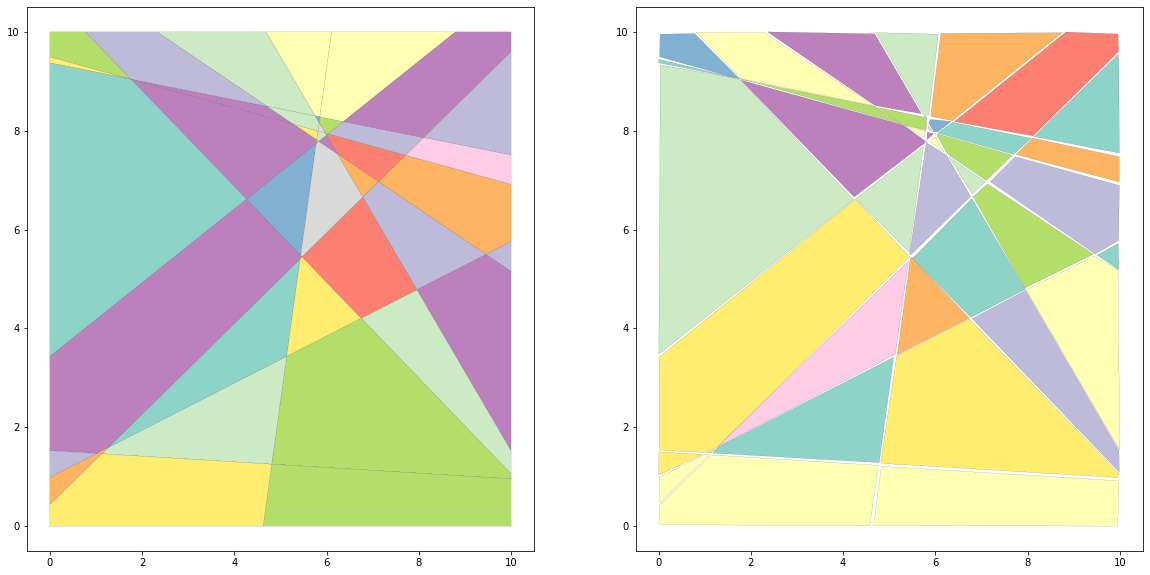

In [386]:
epsilon = 0.1

puzzle = random_puzzle(10)
noised_pieces = [inner_noise(p, epsilon)
                 for p in puzzle.pieces]
shuffled_pieces = randomize_rotation(canonize(noised_pieces))

_, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_puzzle(ax[0], puzzle.pieces)
plot_puzzle(ax[1], noised_pieces)

print(f"num parts: {len(noised_pieces)}")

In [391]:
local_transformations = extract_local_transformations(noised_pieces, puzzle, epsilon)
se_lines = extract_se_lines(local_transformations, epsilon)
ts, rots = execute_sesync(se_lines)
placed_pieces = [(rots[:, 2 * i: 2 * i + 2] @ p.T + ts[:, i].reshape(2, -1)).T
                 for i, p in enumerate(noised_pieces)]


_, ax = plt.subplots(figsize=(10,10))
plot_puzzle(ax, placed_pieces)

interactive(children=(FloatSlider(value=0.25, description='I_coeff', max=0.5), Output()), _dom_classes=('widge…

In [0]:
from ipywidgets import interact
def f(x):
    return x

In [9]:
from google.colab import widgets

ModuleNotFoundError: ignored